# Fetal skin object basic pre-processing and integration

##### Ver:: A1_V2
##### Author(s) : Issac Goh
##### Date : 220523;DDMMYY
### Author notes
    - Due to time contraints, data is being processed using the previously sliced raw expression matrix
    - Previous QC removed 60,000 cells from the raw reads
    - We will proceed with the sliced-raw-expression data of ~185,000 cells and only consider the exprrssion variation amongst these cells
    - Feature normalisation & standardisation does not include cells filtered-out
    
### Assumptions
    - We assume that the major contributors to batch are chemistry and donor information
    - We assume that there are some features of time-variation which can be encoded in unique RNA-variational features.
    
### Method
    - We include batches but purposefully do not include a time encoding in bacthes as we want to learn time-related differences
    - For organoi, we include cell-line but not time
    - We train a VAE model to learn some combination of high dimensional features which represent cell-cell variation, correcting for donors, dataset and chemistry.
    - We learn some featrure of time-relationships between the data.

### Features summary
    - The learned latent representation should encode unique variational composition
    - Due to time constraints, we do not test if this unique variational composition encodes sufficient information to provide accurate decision boundaries between celltype categories
    
### Modes to run in
    - Run in VAE-scvi mode
    - Run in linear-decoded VAE mode

# IG generalised scvi run

In [1]:
# import pickle
# m_pth = '/nfs/team205/ig7/projects/fetal_skin/160523_probabillistic_projection_organoid_adt_fetl/Ni_models/LR_models/fetal_adult_Keratinocyte_by_timepoint.lognorm.pkl'
# with open(m_pth, 'rb') as file:
#     loaded_lr = pickle.load(file)
# loaded_lr

# Fskin - scVI data integration

In [2]:
import sys,os
import scvi
import anndata
import matplotlib
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import numpy as np3
import pandas as pd
import scanpy as sc
import numpy.random as random
import scipy.sparse
import anndata
import numpy as np

Global seed set to 0
/home/jovyan/my-conda-envs/workhorse/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
device = torch.device("cuda")

In [4]:
# /nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/mikola_hannah_agm/IG_datasets/combined_datasets_by_organ/YS_vt_combined_hannah_mikola_all_tp.h5ad
# /nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Integrating_HM_data_030522/YS_logit/YS_vt_HM_YS_LR_raw.h5ad

In [5]:
# scp -o ProxyCommand="ssh -W %h:%p ig7@ssh.sanger.ac.uk" ig7@farm5-login.internal.sanger.ac.uk:/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/mikola_hannah_agm/IG_datasets/combined_datasets_by_organ/YS_vt_combined_hannah_mikola_all_tp.h5ad ./
# scp -o ProxyCommand="ssh -W %h:%p ig7@ssh.sanger.ac.uk" ig7@farm5-login.internal.sanger.ac.uk:/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Integrating_HM_data_030522/YS_logit/YS_vt_HM_YS_LR_raw.h5ad ./

In [6]:
# scp -o ProxyCommand="ssh -W %h:%p ig7@ssh.sanger.ac.uk" ig7@farm5-login.internal.sanger.ac.uk:/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/mikola_hannah_agm/IG_datasets/combined_datasets_by_organ/YolkSac_CS14_mikola_1.h5ad ./
# scp -o ProxyCommand="ssh -W %h:%p ig7@ssh.sanger.ac.uk" ig7@farm5-login.internal.sanger.ac.uk:/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/mikola_hannah_agm/IG_datasets/combined_datasets_by_organ/VitellineV_CS14_mikola_1.h5ad ./

In [7]:
 print(scvi.__version__)

0.20.3


In [8]:
 print(sc.__version__)

1.9.3


In [9]:
 print(anndata.__version__)

0.9.1


# metadata fixing/pruning

In [ ]:
data = {
'fski':'/lustre/scratch126/cellgen/team298/SharedFolders/fetal_skin/data_for_Issac/fetal_skin_raw.h5ad',
'org':'/lustre/scratch126/cellgen/team298/SharedFolders/fetal_skin/data_for_Issac/FS_organoid_raw_count_annot.h5ad',
'adt':'/lustre/scratch126/cellgen/team298/SharedFolders/fetal_skin/data_for_Issac/Healthy_all_data.h5ad',
}
data_pool = {'ski_pool':'/lustre/scratch126/cellgen/team298/SharedFolders/fetal_skin/data_for_Issac/pooled_fetal_organoid_adult.processed.h5ad',
}

In [ ]:
#Extract labels for adt from data_pool
adata_adt_pl = sc.read(data_pool['ski_pool'],backed='r')
adata_adt = sc.read(data['adt'],backed='r')
obs = adata_adt_pl.obs.copy()
obs.index = obs.index.str.replace('-adult','')
obs = obs[obs.index.isin(adata_adt.obs.index)]
obs['donor'] = adata_adt.obs['donor_id'].copy()
adata_adt_sv = adata_adt[adata_adt.obs.index.isin(obs.index)].to_memory()
adata_adt_sv.obs = obs
adata_adt_sv.write('/nfs/team205/ig7/projects/fetal_skin/160523_probabillistic_projection_organoid_adt_fetl/data/adult_healthy/Healthy_adt_qc_raw_sk_annot.h5ad')

In [ ]:
# extract and update fskin data
adata_fsk = sc.read(data['fski'],backed='r')
obs = adata_adt_pl.obs.copy()
obs.index = obs.index.str.replace('-fetal','')
obs = obs[obs.index.isin(adata_fsk.obs.index)] 
obs['donor'] = adata_fsk.obs['donor'].copy()
adata_fsk = adata_fsk[adata_fsk.obs.index.isin(obs.index)].to_memory()
adata_fsk.obs = obs
adata_fsk.write('/nfs/team205/ig7/projects/fetal_skin/160523_probabillistic_projection_organoid_adt_fetl/data/fskin/fetal_qc_sk_raw_annot.h5ad')

In [ ]:
# extract and update organoid data
adata_org = sc.read(data['org'],backed='r')
obs = adata_adt_pl.obs.copy()
obs.index = obs.index.str.replace('-organoid','')
obs = obs[obs.index.isin(adata_org.obs.index)] 
obs['donor'] = adata_org.obs['donor'].copy()
adata_org = adata_org[adata_org.obs.index.isin(obs.index)].to_memory()
adata_org.obs = obs
adata_org.write('/nfs/team205/ig7/projects/fetal_skin/160523_probabillistic_projection_organoid_adt_fetl/data/organoid/organoid_qc_sk_raw_annot.h5ad')

# Prepare dataset mergers

In [ ]:
run_id = 'A1_V1_linear_ldvae_scvi_ski_updated_org_adt_build_donor_source_corrected_160523'
# Required: Introduce the path you'd like to save figures or data to 
save_path = "/nfs/team205/ig7/projects/fetal_skin/3_160523_probabillistic_projection_organoid_adt_fetl/data/"

In [ ]:
# #Raw obj paths
data_updated = {
'-fetal':'/nfs/team205/ig7/projects/fetal_skin/160523_probabillistic_projection_organoid_adt_fetl/data/organoid/organoid_qc_sk_raw_annot.h5ad',
'-organoid':'/nfs/team205/ig7/projects/fetal_skin/160523_probabillistic_projection_organoid_adt_fetl/data/organoid/organoid_qc_sk_raw_annot.h5ad',
'-adult':'/nfs/team205/ig7/projects/fetal_skin/160523_probabillistic_projection_organoid_adt_fetl/data/adult_healthy/Healthy_adt_qc_raw_sk_annot.h5ad',
}
data_merge = True
QC_normalise = False
data_key_use = None

In [ ]:
def load_adatas(adatas_dict,data_merge, data_key_use,QC_normalise):
    if data_merge == True:
        # Read
        gene_intersect = {} # unused here
        adatas = {}
        for dataset in adatas_dict.keys():
            if 'https' in adatas_dict[dataset]:
                print('Loading anndata from web source')
                adatas[dataset] = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[dataset])
            print('Loading anndata {} from local source'.format(dataset))
            adatas[dataset] = sc.read(adatas_dict[dataset])
            adatas[dataset].var_names_make_unique()
            adatas[dataset].obs['dataset_merge'] = dataset
            adatas[dataset].obs['dataset_merge'] = dataset
#             adatas[dataset].obs.index = adatas[dataset].obs.index + dataset
            gene_intersect[dataset] = list(adatas[dataset].var.index)
            print('All datasets successfully read into a dictionary')
        print('Attempting to collapse dictionary into single joint concatenation')
        adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],join='inner',index_unique=None) # consider only genes that are intersecting
        return adatas, adata
    elif data_merge == False:
        if 'https' in adatas_dict[data_key_use]:
            print('Loading anndata from web source')
            adata = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[data_key_use])
        else: 
            adata = sc.read(adatas_dict[data_key_use])
    if QC_normalise == True:
        print('option to apply standardisation to data detected, performing basic QC filtering')
        adata.raw = adata[:]
        sc.pp.filter_cells(adata, min_genes=200)
        sc.pp.filter_genes(adata, min_cells=3)
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
        sc.pp.log1p(adata)
    return adata

# Read
adatas , adata_raw = load_adatas(data_updated, data_merge ,data_key_use, QC_normalise)
adata_raw.write(save_path+run_id+'_raw_concatenated_full_features.h5ad')

## Load and prep data

In [19]:
adata_raw = sc.read("/nfs/team205/ig7/projects/fetal_skin/3_160523_probabillistic_projection_organoid_adt_fetl/data/A1_V1_ldvae_scvi_ski_updated_org_adt_build_donor_source_corrected_160523_raw_concatenated_HVG_features.h5ad")

In [20]:
adata = adata_raw[:]

# High var

In [21]:
#adata_raw.write(save_path + '/run_'+ run_id+'_raw_feature_selected.h5ad')

In [22]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)

/home/jovyan/my-conda-envs/workhorse/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [23]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

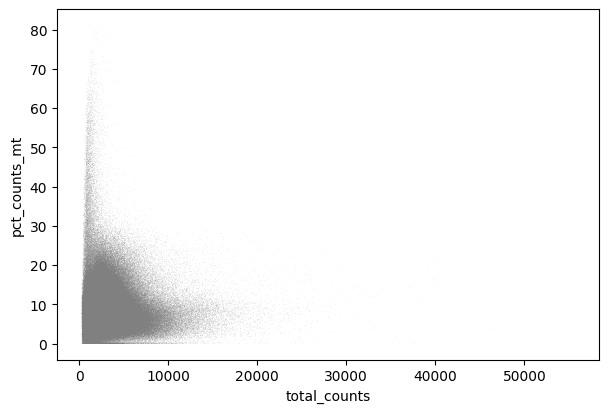

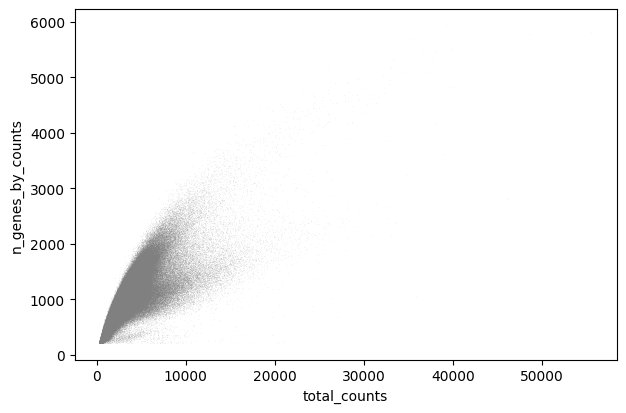

In [24]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [25]:
# adata = adata[adata.obs.n_genes_by_counts < 5000, :]
# adata = adata[adata.obs.pct_counts_mt < 5, :]
adata

AnnData object with n_obs × n_vars = 493293 × 14999
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'day', 'sample_id', 'version', 'week', 'nh3_annot1', 'log1p_n_counts', 'log1p_n_genes', 'n_counts_mito', 'n_counts_ribo', 'n_

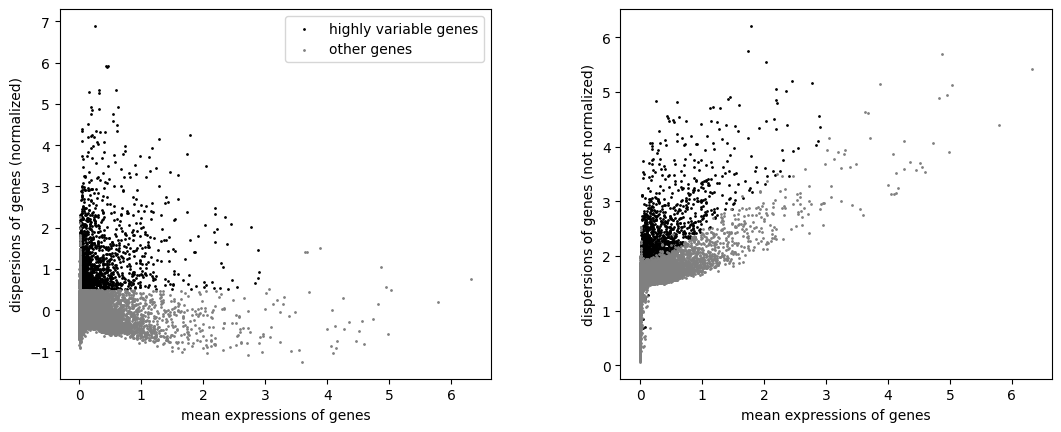

In [26]:
#sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, batch_key = "donor", subset=False)
sc.pl.highly_variable_genes(adata)

### Add batch key
Here we concatenate library prep method and donor of origin

## Param sweep for feature selection

In [27]:
import torch
device = torch.device("cuda")

def subset_top_hvgs(adata_lognorm, n_top_genes):
    dispersion_norm = adata_lognorm.var['dispersions_norm'].values.astype('float32')

    dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
    dispersion_norm[
                ::-1
            ].sort()  # interestingly, np.argpartition is slightly slower

    disp_cut_off = dispersion_norm[n_top_genes - 1]
    gene_subset = adata_lognorm.var['dispersions_norm'].values >= disp_cut_off
    return(adata_lognorm[:,gene_subset])

def prep_scVI(adata, 
              n_hvgs = 5000,
              remove_cc_genes = True,
              remove_tcr_bcr_genes = False
             ):
    ## Remove cell cycle genes
    if remove_cc_genes:
        adata = panfetal_utils.remove_geneset(adata,genes.cc_genes)

    ## Remove TCR/BCR genes
    if remove_tcr_bcr_genes:
        adata = panfetal_utils.remove_geneset(adata, genes.IG_genes)
        adata = panfetal_utils.remove_geneset(adata, genes.TCR_genes)
        
    ## HVG selection
    adata = subset_top_hvgs(adata, n_top_genes=n_hvgs)
    return(adata)

def train_scVI(adata, n_dims=20):
    adata = scvi.data.setup_anndata(adata, batch_key = "bbk", copy=True)
    vae = scvi.model.SCVI(adata, n_latent=n_dims)
    vae.train(use_gpu=True, batch_size=256) ## increasing batch size as in retina atlas
    return(vae.get_latent_representation())
    
def save_scVI(adata, 
              timestamp,
              n_hvgs = 5000,
              remove_cc_genes = True,
                remove_tcr_bcr_genes = False,
                n_dims=20
             ):
    outname = "YS_project".format(t=timestamp, h=n_hvgs, cc=cc, tcr=tcr, n=n_dims)
    np.save(data_dir + outname, adata.obsm["X_scVI"])

def train_ldvae(adata, labels_key,batch, n_dims=20):
    arches_params = dict(
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
    n_hidden=256)
    
    scvi.model.LinearSCVI.setup_anndata(
    adata,
    labels_key = labels_key,
    layer=None,
    batch_key=batch)
    
    vae = scvi.model.LinearSCVI(adata, n_latent=30, **arches_params)
    #vae = scvi.model.SCVI(adata, n_latent=30,n_hidden=256, **arches_params)
    vae.train(early_stopping=True,
        train_size=0.9,
        early_stopping_patience=45,
        max_epochs=500, 
        batch_size=1024, 
        limit_train_batches=20
       )
    X_scvi = vae.get_latent_representation()
    X_loading = vae.get_loadings()
    adata.obsm['X_scvi'] = X_scvi
    adata.varm['X_scvi'] = X_loading
    sc.pp.neighbors(adata,n_neighbors=15, use_rep='X_scvi', n_pcs = 30)
    return adata 


In [28]:
nhvgs = [5000,7500,10000]
dims = [10,20,30]

In [29]:
# for n in nhvgs:
#     for r in remove:
#         adata1 = prep_scVI(adata_raw, n_hvgs=n, remove_cc_genes=None, remove_tcr_bcr_genes=None)
#         for d in dims:
            
#             adata1.obsm["X_scVI"] = train_scVI(adata1, n_dims=d)
#             save_scVI(adata1, timestamp=timestamp, n_hvgs=n, None, remove_tcr_bcr_genes=None, n_dims=d)
#         del adata1
#         gc.collect()

# Subset_HVGS

In [30]:
# adata = adata_raw[:]

In [31]:
# sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, batch_key = "fetal.ids", subset=False)
# sc.pl.highly_variable_genes(adata)

In [ ]:
adata = subset_top_hvgs(adata,14999)
var_genes = pd.DataFrame(list(adata.var.index))
#var_genes.to_csv(save_path + '/run_'+ run_id+'_var_genes.csv')
#adata.write(save_path + '/run_'+ run_id+'_norm_feature_selected.h5ad')

adata_raw = adata_raw[:, adata_raw.var_names.isin(list(var_genes.iloc[:,0]))]
adata_raw.layers['raw_counts'] = adata_raw.X.copy()
#adata_raw.write(save_path + '/run_'+ run_id+'_raw_feature_selected.h5ad')

In [ ]:
adata_raw

## Run scVI integration
We train using parameters optimized for online update with `scArches`, to be able to add query datasets in the future. Following the [scvi-tools vignette](https://docs.scvi-tools.org/en/stable/user_guide/notebooks/scarches_scvi_tools.html?highlight=encode_covariates#Train-reference).

In [ ]:
adata = adata_raw.copy()

In [ ]:
adata.write(save_path+run_id+'_raw_concatenated_HVG_features.h5ad')

In [10]:
adata = sc.read('/nfs/team205/ig7/projects/fetal_skin/3_160523_probabillistic_projection_organoid_adt_fetl/data/A1_V1_ldvae_scvi_ski_updated_org_adt_build_donor_source_corrected_160523_raw_concatenated_HVG_features.h5ad')
# adata_raw = sc.read('/home/jupyter/mount/gdrive/g_cloud/projects/YS/data/A5_V1_YS_build_120522/run_A5_V1_YS_build_120522_raw_feature_selected.h5ad')

In [11]:
# adata_raw.write('/home/jupyter/mount/gdrive/g_cloud/projects/YS/data/A5_V1_YS_build_120522/run_A5_V3_YS_build_120522_raw_feature_selected_high_var.h5ad')

In [12]:
# adata = prep_scVI(adata_raw, n_hvgs=7500, remove_cc_genes=True, remove_tcr_bcr_genes=True)

In [13]:
# adata.obs['chemistry_ver'] = 'V1'
# adata.obs.loc[adata.obs['orig.dataset'].isin(['YS_WE']),'chemistry_ver'] = 'V2'
# adata.obs['lr_batch'] = adata.obs['fetal.ids'].astype(str) + '_' + adata.obs['chemistry_ver'].astype(str)  + '_' + adata.obs['donor'].astype(str) 

In [14]:
data_pool = {'ski_pool':'/lustre/scratch126/cellgen/team298/SharedFolders/fetal_skin/data_for_Issac/pooled_fetal_organoid_adult.processed.h5ad',
}
adata_adt_pl = sc.read(data_pool['ski_pool'],backed='r')
adata.obs['annot'] = adata.obs['annot'].astype(str)
idx = adata.obs[adata.obs['annot']=='nan'].index
adata.obs.loc[adata.obs.index.isin(idx),'annot'] = adata_adt_pl.obs.loc[adata_adt_pl.obs.index.isin(idx),'annot']

In [15]:
batches =  ['chemistry','dataset'] #donor
adata.obs['dataset'] = adata.obs['dataset'].astype(str)
adata.obs.loc[adata.obs.index.str.contains('organoid'),'dataset'] = 'organoid'
adata.obs.loc[adata.obs['chemistry'].isin(['nan']),'chemistry'] = np.nan
adata.obs['chemistry'] = adata.obs['chemistry'].fillna('nan')
adata.obs['chemistry'].unique()

adata.obs['lr_batch'] = adata.obs['dataset'].astype(str) + '_' + adata.obs['chemistry'].astype(str)#  + '_' + adata.obs['donor'].astype(str) 
labels_key = 'annot'
lin_vae = True

In [16]:
import scvi
import importlib
importlib.reload(scvi)

<module 'scvi' from '/home/jovyan/my-conda-envs/workhorse/lib/python3.9/site-packages/scvi/__init__.py'>

In [ ]:
if lin_vae == True:
    arches_params = dict(
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
    n_hidden=256)

    scvi.model.LinearSCVI.setup_anndata(
    adata,
    labels_key = 'annot',
    layer=None,
    batch_key='lr_batch')

    vae = scvi.model.LinearSCVI(adata, n_latent=30, **arches_params)
    #vae = scvi.model.SCVI(adata, n_latent=30,n_hidden=256, **arches_params)
    vae.train(early_stopping=True,
        train_size=0.9,
        early_stopping_patience=45,
        max_epochs=500, 
        batch_size=1024, 
        limit_train_batches=20
       )
    X_scvi = vae.get_latent_representation()
    X_loading = vae.get_loadings()
    adata.obsm['X_scvi'] = X_scvi
    adata.varm['X_scvi'] = X_loading
else:
    scvi.model.SCVI.setup_anndata(
    adata,
    layer=None,
    categorical_covariate_keys = batches,
    )
    arches_params = dict(
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
    n_hidden=256
    )
    vae = scvi.model.SCVI(adata, n_latent=30,**arches_params)
    vae.train(early_stopping=True,
            train_size=0.9,
            early_stopping_patience=45,
            max_epochs=250, 
            batch_size=1024, 
            limit_train_batches=20
           )
    X_scvi = vae.get_latent_representation()
    adata.obsm['X_scvi'] = X_scvi

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 268/500:  53%|█████▎    | 267/500 [3:58:17<3:41:31, 57.05s/it, loss=3.31e+03, v_num=1]

In [ ]:
pd.DataFrame(X_scvi).to_csv('./linear_v2_ldvae_X_scvi.csv')
pd.DataFrame(X_loading).to_csv('./linear_v2_ldvae_X_scvi_weights.csv')

In [ ]:
sc.pp.neighbors(adata,n_neighbors=30, use_rep='X_scvi', n_pcs = 30)

In [ ]:
adata.write(save_path+run_id+'_v2_raw_concatenated_linear_ldvae_xscvi_features.h5ad')

### Check convergence

In [ ]:
data_dir = save_path
timestamp = '20220906'

In [ ]:
sns.set_context("talk")
plt.plot(vae.history["elbo_train"], label="Training");
plt.plot(vae.history["elbo_validation"], label="Validation");
plt.legend();
plt.xlabel("epoch");
plt.ylabel("ELBO");
plt.savefig("./scvi_training_elbo.pdf", bbox_inches="tight")

In [ ]:
sns.set_context("talk")
plt.plot(vae.history["train_loss_step"], label="train");
# plt.plot(vae.history["reconstruction_loss_validation"], label="validation");
plt.xlabel("epoch");
plt.ylabel("Train loss");

In [ ]:
## Save embedding
x_scvi = vae.get_latent_representation()
outname = './'+run_id+"_ld.npy"
np.save(outname, x_scvi)

In [ ]:
model_dir = '/nfs/team205/ig7/projects/fetal_skin/160523_probabillistic_projection_organoid_adt_fetl/data/'

In [ ]:
# save the reference model
vae.save(dir_path = (save_path + run_id), overwrite=False, save_anndata=False)
vae.save(dir_path = (model_dir + run_id), overwrite=False, save_anndata=False)

In [ ]:
## Save the obs
adata.obs.to_csv('./'+run_id+".csv")

In [ ]:
## Save training stats
model_history = vae.history.copy()
model_history.pop('train_loss_step')
pd.DataFrame.from_dict({k:v[k] for k,v in model_history.items()}).to_csv("panf_data_raw_count.{t}.scVI_out.train_history.csv".format(t=timestamp))

In [ ]:
# save the reference model
model_dir = 'ldscvi_PFI_model/'
if not os.path.exists(data_dir + model_dir):
    os.mkdir(data_dir + model_dir)
vae.save(data_dir + model_dir, overwrite=True)

## Explore output

In [ ]:
# adata.obsm['X_scvi'] = vae.get_latent_representation() 
sc.pp.neighbors(adata, n_neighbors=30,use_rep='X_scvi')
sc.tl.umap(adata, min_dist = 0.01)
# Clustering
# res = 5
sc.pl.umap(adata,color = 'cell.labels',size =10)
sc.pl.umap(adata,color = 'organ',size =10)

In [ ]:
sc.pl.umap(adata,color = 'organ',size =10)

In [ ]:
sc.pl.umap(adata,color = 'organ',size =10)

In [ ]:
var = "organ"
#Create color dictionary_cell
cells = list(adata.obs[var].cat.categories)
col = list(range(0, len(adata.obs[var].cat.categories)))
#col = adata.uns['cell.labels_colors']
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var]
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)

col_pal = ['#ff0000',    '#94BFB1',    '#B49EC8',    '#E0EE70',    '#EE943E',    '#4C7BAB',    '#E78AB8',    '#AFBFCC',    '#FF993F',    "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF"]

import matplotlib
matplotlib.rcdefaults() #Reset matplot lb deafults as seaborne tends to mess with this
fig, (ax1, ax2,) = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1,0]})
p2 = sc.pl.umap(adata, color = (var+'_num') ,ax=ax2,show=False,title="", palette= col_pal) #title=i
p3 = sc.pl.umap(adata, color = "num",legend_loc="on data",size=2,legend_fontsize='small',ax=ax1,show=False,title="Myeloid_broad", palette= col_pal) #title=i

fig.savefig('./'+var+"_num.pdf",bbox_inches='tight')

In [ ]:
var = "celltype_annotation"
#Create color dictionary_cell
cells = list(adata.obs[var].cat.categories)
col = list(range(0, len(adata.obs[var].cat.categories)))
#col = adata.uns['cell.labels_colors']
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var]
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)

col_pal = ['#ff0000',    '#94BFB1',    '#B49EC8',    '#E0EE70',    '#EE943E',    '#4C7BAB',    '#E78AB8',    '#AFBFCC',    '#FF993F',    "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF"]

import matplotlib
matplotlib.rcdefaults() #Reset matplot lb deafults as seaborne tends to mess with this
fig, (ax1, ax2,) = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1,0]})
p2 = sc.pl.umap(adata, color = (var+'_num') ,ax=ax2,show=False,title="", palette= col_pal) #title=i
p3 = sc.pl.umap(adata, color = "num",legend_loc="on data",size=2,legend_fontsize='small',ax=ax1,show=False,title="Myeloid_broad", palette= col_pal) #title=i

fig.savefig('./'+var+"_num.pdf",bbox_inches='tight')

In [ ]:
adata.write(save_path + run_id + '.h5ad')

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs = 50)
sc.tl.umap(adata)
# Clustering
# res = 5
sc.pl.umap(adata,color = 'cell.labels',size =10)
sc.pl.umap(adata,color = 'tissue',size =10)

In [11]:
# adata = sc.read(save_path + run_id + '.h5ad')

In [ ]:
adata.obsm

In [12]:
sc.pl.umap(adata,color = 'cell.labels',size =10)
sc.pl.umap(adata,color = 'organ',size =10)

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

In [ ]:
adata.write(save_path + run_id + '.h5ad')

In [ ]:
adata.obsm['X_scvi'] = vae.get_latent_representation() 
sc.pp.neighbors(adata, n_neighbors=10,use_rep='X_scvi', n_pcs = 15)
sc.tl.umap(adata)
# Clustering
# res = 5
sc.pl.umap(adata,color = 'cell.labels',size =10)
sc.pl.umap(adata,color = 'tissue',size =10)

In [ ]:
adata.write('./A2_V8_YS_EL_build_scvi_220522_10_15.h5ad')

In [ ]:
adata.obsm['X_scvi'] = vae.get_latent_representation() 
sc.pp.neighbors(adata, n_neighbors=10,use_rep='X_scvi', n_pcs = 20)
sc.tl.umap(adata)
# Clustering
# res = 5
sc.pl.umap(adata,color = 'cell.labels',size =10)
sc.pl.umap(adata,color = 'tissue',size =10)

In [ ]:
adata.write('./A2_V8_YS_EL_build_scvi_220522_10_20.h5ad')

In [ ]:
sc.pl.umap(adata,color = 'tissue',size =10)